# Example Keller-Segel model

In [18]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions

from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.model.func_approx import NN
from deepymod.model.library import Library1D
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold, PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)

# Configuring GPU or CPU
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


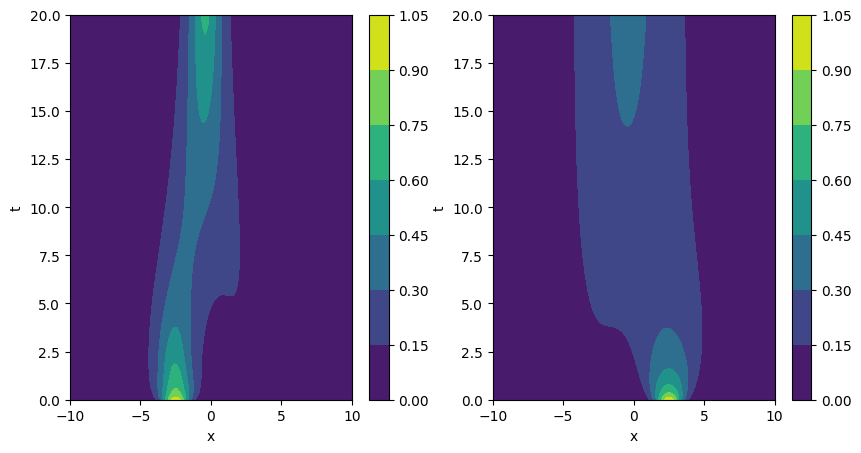

In [19]:
data = np.load('data/keller_segel.npy', allow_pickle=True).item()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

im = axs[0].contourf(data['x'], data['t'], np.real(data['u']))
axs[0].set_xlabel('x')
axs[0].set_ylabel('t')
fig.colorbar(mappable=im, ax=axs[0])

im = axs[1].contourf(data['x'], data['t'], np.real(data['v']))
axs[1].set_xlabel('x')
axs[1].set_ylabel('t')
fig.colorbar(mappable=im, ax=axs[1])

plt.show()


In [20]:
def load_data():
    data = np.load('data/keller_segel.npy', allow_pickle=True).item()
    coords = torch.from_numpy(np.stack((data["t"],data["x"]), axis=-1)).float()
    data = torch.from_numpy(np.stack((data["u"],data["v"]), axis=-1)).float()
    return coords, data

coords, data = load_data()

In [21]:
data.shape

torch.Size([101, 101, 2])

In [22]:
dataset = Dataset(
    load_data,
    preprocess_kwargs={
        "noise_level": 0.00,
        "normalize_coords": False,
        "normalize_data": False,
    },
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 2000},
    device=device,
)

Preprocessing data
Dataset is using device:  cuda


In [23]:
dataset.data.shape

torch.Size([2000, 2])

In [24]:
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.8)

In [8]:
network = NN(2, [30, 30, 30, 30], 2)

In [9]:
library = Library1D(poly_order=1, diff_order=2) 

In [10]:
estimator = Threshold(0.5) 
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5) 

In [11]:
constraint = LeastSquares() 
# Configuration of the sparsity scheduler

In [12]:
model = DeepMoD(network, library, estimator, constraint).to(device)

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3) 


In [13]:
%%time
!rm -rf ./data/deepymod/keller_segel/
foldername = "./data/deepymod/keller_segel/"
train(model, 
train_dataloader, 
test_dataloader, 
optimizer,
sparsity_scheduler, 
log_dir=foldername, 
split=0.8, 
max_iterations=100000) 

 56500  MSE: 2.76e-02  Reg: 4.08e-05  L1: 3.31e+01 Algorithm converged. Writing model to disk.
CPU times: user 50min 7s, sys: 1min 15s, total: 51min 22s
Wall time: 50min 5s


/tmp/ipykernel_3818071/1364238544.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tag] = data[idx]
/tmp/ipykernel_3818071/1364238544.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tag] = data[idx]
/tmp/ipykernel_3818071/1364238544.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  

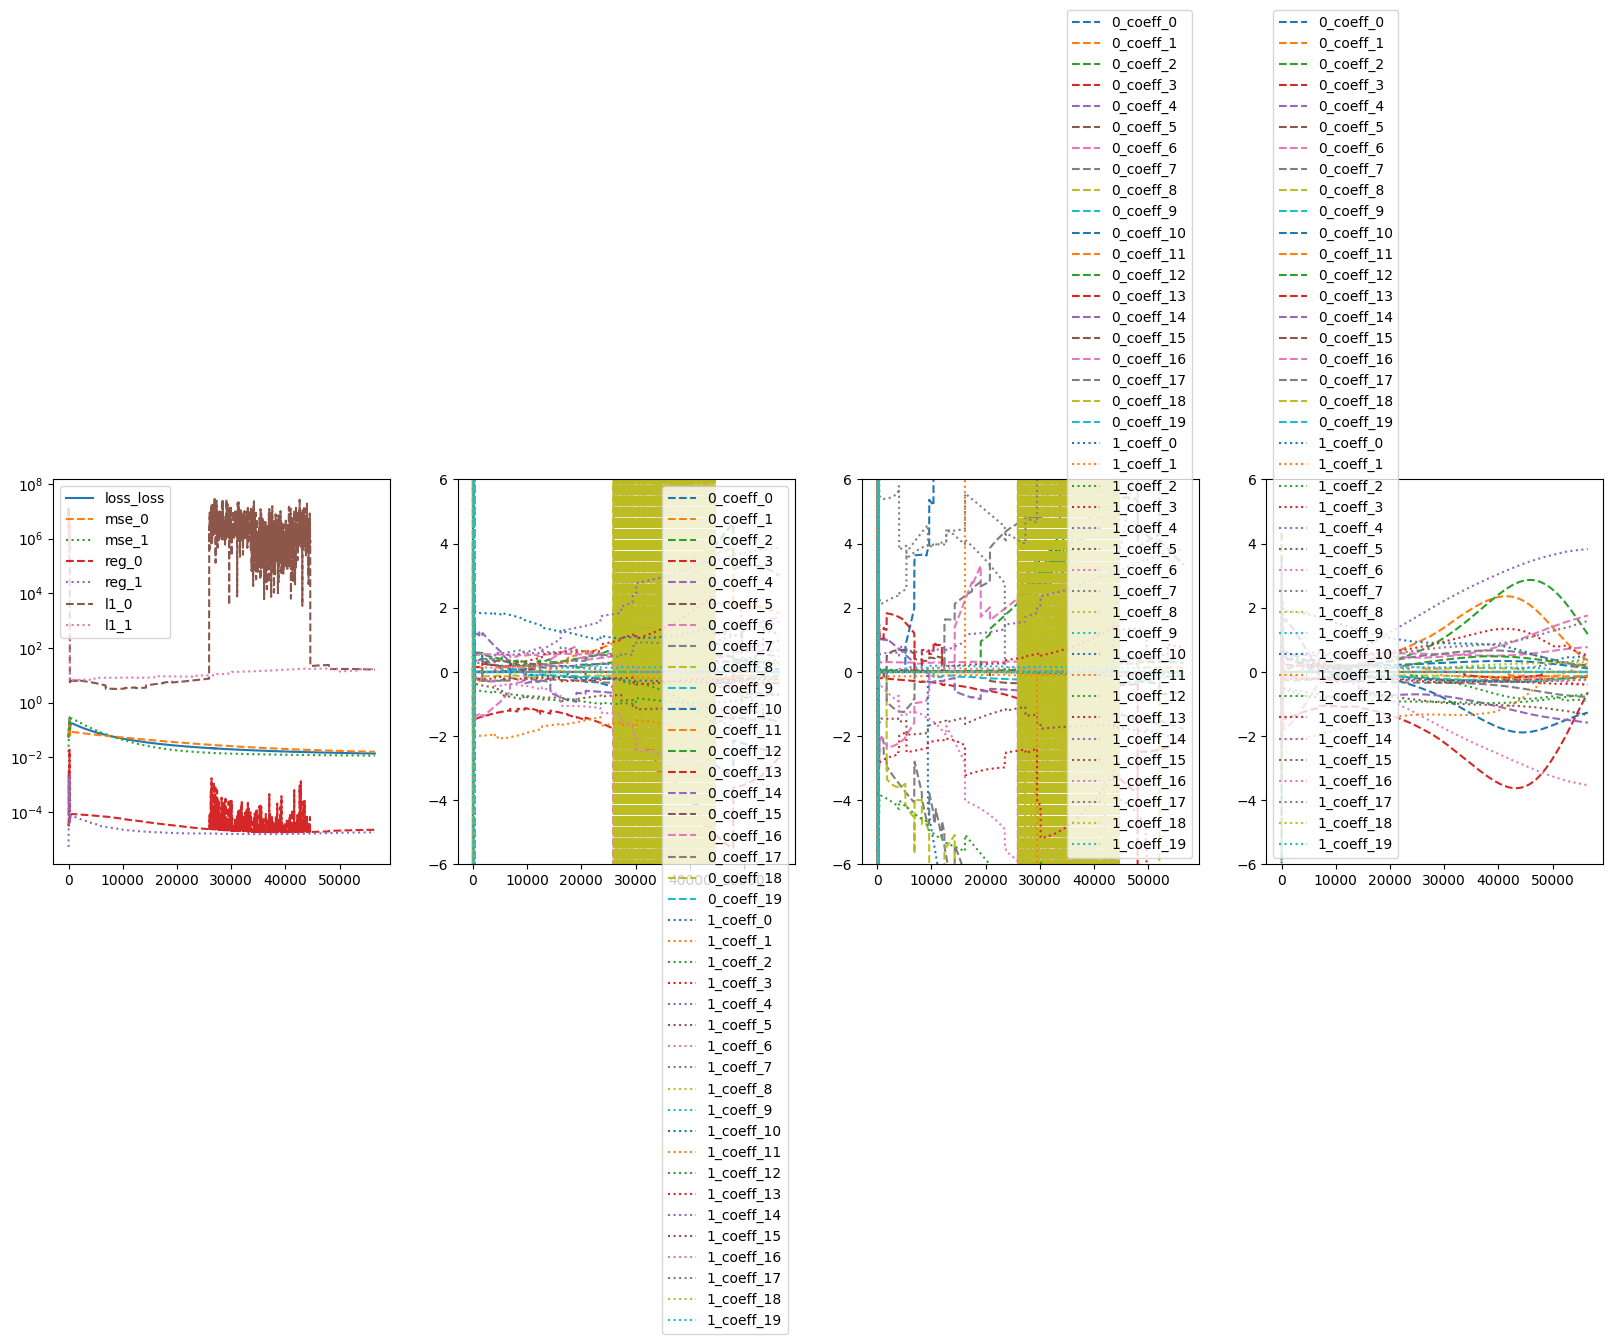

In [14]:
from deepymod.analysis import load_tensorboard

import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os
from natsort import natsorted
import matplotlib.pyplot as plt
import traceback
def load_tensorboard2(path: str) -> pd.DataFrame:
    """Loads tensorboard files into a pandas dataframe. Assumes one run per folder!

    Args:
        path (string): path of folder with tensorboard files.

    Returns:
        DataFrame: Pandas dataframe with all run data.
    """

    event_paths = [
        file
        for file in os.walk(path, topdown=True)
        if file[2][0][: len("events")] == "events"
    ]

    df = pd.DataFrame()
    steps = None  # steps are the same for all files

    for event_idx, path in enumerate(event_paths):
        summary_iterator = EventAccumulator(os.path.join(path[0], path[2][0])).Reload()
        tags = summary_iterator.Tags()["scalars"]
        data = [
            [event.value for event in summary_iterator.Scalars(tag)] for tag in tags
        ]
        if steps is None:
            steps = [event.step for event in summary_iterator.Scalars(tags[0])]

        # Adding to dataframe
        tags = [tag.replace("/", "_") for tag in tags]  # for name consistency
        if (
            event_idx > 0
        ):  # We have one file in the top level, so after we need to use folder name
            tags = [path[0].split("/")[-1]]

        for idx, tag in enumerate(tags):
            try:
                df[tag] = data[idx]
            except ValueError: # more debugging info
                print(f"Warning: Either the {tag = } of `df` or {idx = } of `data` do not exist! Check for pre-existing saved files. ")
        df.index = steps
    return df

history = load_tensorboard2(foldername) 
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for history_key in history.keys():
    history_key_parts = history_key.split("_")
    if history_key_parts[0] == "loss":    
        if history_key_parts[-1] == "0":
            axs[0].semilogy(history[history_key], label=history_key_parts[1]+"_"+history_key_parts[-1], linestyle="--")
        elif history_key_parts[-1] == "1":
            axs[0].semilogy(history[history_key],  label=history_key_parts[1]+"_"+history_key_parts[-1], linestyle=":")
        else:
            axs[0].semilogy(history[history_key],  label=history_key_parts[1]+"_"+history_key_parts[-1], linestyle="-")
        if history_key_parts[0] == "remaining":    
            axs[0].semilogy(history[history_key],  label=history_key_parts[1]+"_"+history_key_parts[3]+"_"+history_key_parts[4], linestyle="-.")
    if history_key_parts[0] == "coeffs":
        if history_key_parts[2] == "0":
            axs[1].plot(history[history_key], label=history_key_parts[2]+"_"+history_key_parts[3]+"_"+history_key_parts[4], linestyle="--")
        elif history_key_parts[2] == "1":
            axs[1].plot(history[history_key], label=history_key_parts[2]+"_"+history_key_parts[3]+"_"+history_key_parts[4], linestyle=":")
        else:
            axs[1].plot(history[history_key], label=history_key_parts[2]+"_"+history_key_parts[3]+"_"+history_key_parts[4], linestyle="-")
    if history_key_parts[0] == "unscaled":    
        if history_key_parts[3] == "0":
            axs[2].plot(history[history_key], label=history_key_parts[3]+"_"+history_key_parts[4]+"_"+history_key_parts[5], linestyle="--")
        elif history_key_parts[3] == "1":
            axs[2].plot(history[history_key], label=history_key_parts[3]+"_"+history_key_parts[4]+"_"+history_key_parts[5], linestyle=":")
        else:
            axs[2].plot(history[history_key], label=history_key_parts[3]+"_"+history_key_parts[4]+"_"+history_key_parts[5], linestyle="-")
    if history_key_parts[0] == "estimator":    
        if history_key_parts[3] == "0":
            axs[3].plot(history[history_key], label=history_key_parts[3]+"_"+history_key_parts[4]+"_"+history_key_parts[5], linestyle="--")
        elif history_key_parts[3] == "1":
            axs[3].plot(history[history_key], label=history_key_parts[3]+"_"+history_key_parts[4]+"_"+history_key_parts[5], linestyle=":")
        else:
            axs[3].plot(history[history_key], label=history_key_parts[3]+"_"+history_key_parts[4]+"_"+history_key_parts[5], linestyle="-")

#axs[0].set_ylim([-2, 2])
axs[1].set_ylim([-6, 6])
axs[2].set_ylim([-6, 6])
axs[3].set_ylim([-6, 6])

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()

plt.show()


In [15]:
model.constraint_coeffs()[0].shape

torch.Size([20, 1])

In [16]:
model.constraint_coeffs()

[tensor([[-2.3521e-02],
         [ 1.3281e-01],
         [ 2.8763e-01],
         [-2.0156e+00],
         [-1.7787e+00],
         [-6.0790e-01],
         [ 4.0887e-01],
         [-3.5436e+01],
         [ 0.0000e+00],
         [-9.9599e-02],
         [ 8.2289e+00],
         [-1.9927e+01],
         [ 3.3474e+00],
         [ 0.0000e+00],
         [ 0.0000e+00],
         [ 0.0000e+00],
         [ 1.4118e+01],
         [ 6.2491e+00],
         [ 0.0000e+00],
         [ 0.0000e+00]], device='cuda:0', grad_fn=<MaskedScatterBackward0>),
 tensor([[ 8.0590e-03],
         [-1.5388e-02],
         [-1.2960e-01],
         [ 8.0129e-01],
         [ 3.8341e+00],
         [-2.1709e+00],
         [-1.9775e-01],
         [ 1.6871e+01],
         [ 2.4426e+01],
         [ 0.0000e+00],
         [-1.7566e+01],
         [-2.4503e+01],
         [-8.1093e+00],
         [-7.0709e+00],
         [ 0.0000e+00],
         [ 0.0000e+00],
         [-2.5160e+01],
         [ 1.7187e+01],
         [ 0.0000e+00],
         [ 

In [17]:
model.estimator_coeffs()

[array([[-1.2666515 ],
        [ 0.35769352],
        [ 1.1689028 ],
        [-0.6338119 ],
        [-1.579627  ],
        [-0.15181023],
        [ 0.7732166 ],
        [-0.77279645],
        [ 0.        ],
        [-0.10461701],
        [ 0.11130317],
        [-0.12082438],
        [ 0.20782565],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 1.7622671 ],
        [ 0.13914454],
        [ 0.        ],
        [ 0.        ]], dtype=float32),
 array([[ 0.5475759 ],
        [ 0.25207973],
        [-0.9102144 ],
        [ 0.5310744 ],
        [ 3.8280046 ],
        [-1.3439515 ],
        [-0.39983183],
        [ 0.40923002],
        [ 0.3029539 ],
        [ 0.        ],
        [-0.22869217],
        [-0.25412074],
        [-0.6813107 ],
        [-0.3913725 ],
        [ 0.        ],
        [ 0.        ],
        [-3.527132  ],
        [ 1.5917106 ],
        [ 0.        ],
        [ 0.        ]], dtype=float32)]

In [18]:
for batch_idx, (input1, target) in enumerate(train_dataloader):
    print(f"Batch {batch_idx} - Input shape: {input1.shape}, Target shape: {target.shape}")
    prediction, time_derivs, thetas = model(input1)
    print(f"{prediction.shape = }, {len(time_derivs) = }, {len(thetas) = }")
    print(f"{time_derivs[0].shape = }, {thetas[0].shape = }")

Batch 0 - Input shape: torch.Size([8000, 2]), Target shape: torch.Size([8000, 2])
prediction.shape = torch.Size([8000, 2]), len(time_derivs) = 2, len(thetas) = 1
time_derivs[0].shape = torch.Size([8000, 1]), thetas[0].shape = torch.Size([8000, 20])
